In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, precision_recall_curve, auc
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn.preprocessing import label_binarize
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline, make_pipeline
import matplotlib.pyplot as plt
import joblib
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [2]:
train_df = pd.read_csv("./processed-data/processed_data_train.csv")
test_df = pd.read_csv("./processed-data/processed_data_test.csv")

train_df.head()

,temp_c,condition,wind_kph,pressure_in,precip_mm,snow_cm,humidity,cloud,vis_km,uv,hour_sin,hour_cos,month_sin,month_cos,wind_degree_sin,wind_degree_cos,dewpoint_depression
0,0.901420,7,-0.544269,-1.702582,-0.205408,-0.032943,0.653087,0.116381,0.23672,-0.906157,0.366506,1.364709,-0.701803,-1.213762,-1.414583,-0.029929,-0.182125
1,0.495247,9,1.392931,0.033613,-0.205408,-0.032943,-0.360737,-0.993660,0.23672,1.310283,1.000829,-1.000022,-1.220815,-0.697459,0.534746,1.216967,0.186417
2,0.698334,1,0.431839,-0.559234,-0.205408,-0.032943,0.399631,1.036902,0.23672,-0.906157,-1.225136,0.706151,-1.410787,0.007825,-1.103593,-0.920732,-0.115367
3,-1.632327,1,-1.355190,0.584113,-0.205408,-0.032943,-0.614193,0.576641,0.23672,-0.589523,-1.225136,-0.707289,0.716166,1.229412,1.303438,-0.803327,-0.174110
4,0.263148,7,-0.334031,-0.178118,-0.205408,-0.032943,0.805161,0.224677,0.23672,0.993649,1.415269,-0.000569,-1.410787,0.007825,1.199124,0.784002,-0.306822


In [3]:
X_train = train_df.drop(columns=['condition'])
y_train = train_df['condition']
X_test = test_df.drop(columns=['condition'])
y_test = test_df['condition']

In [4]:
label_encoder = joblib.load("label_encoder.pkl")
class_names = label_encoder.classes_

In [24]:
from imblearn.pipeline import make_pipeline
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

pipeline_xgb = make_pipeline(
    SMOTETomek(sampling_strategy='auto', random_state=42),
    XGBClassifier(n_estimators=800, max_depth=6, random_state=42,
                   use_label_encoder=False, eval_metric='mlogloss')
)
pipeline_xgb.fit(X_train, y_train)

# Dự đoán
y_pred_xgb = pipeline_xgb.predict(X_test)


print("Classification Report:\n",
      classification_report(y_test, y_pred_xgb, target_names=class_names))


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:54:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
                      precision    recall  f1-score   support

              Clear       1.00      0.99      1.00      4100
    Cloudy/Overcast       0.99      1.00      1.00      3619
            Drizzle       0.99      1.00      0.99      1807
           Fog/Mist       0.75      0.67      0.71         9
      Freezing Rain       0.96      0.94      0.95        71
         Light Rain       0.64      0.29      0.40        31
Moderate/Heavy Rain       0.98      1.00      0.99      1247
      Partly cloudy       0.99      0.98      0.98      2658
               Snow       1.00      1.00      1.00        26
              Sunny       1.00      1.00      1.00      3987
            Thunder       0.80      0.44      0.57         9

           accuracy                           0.99     17564
          macro avg       0.92      0.85      0.87     17564
       weighted avg       0.99      0.99      0.99     17564



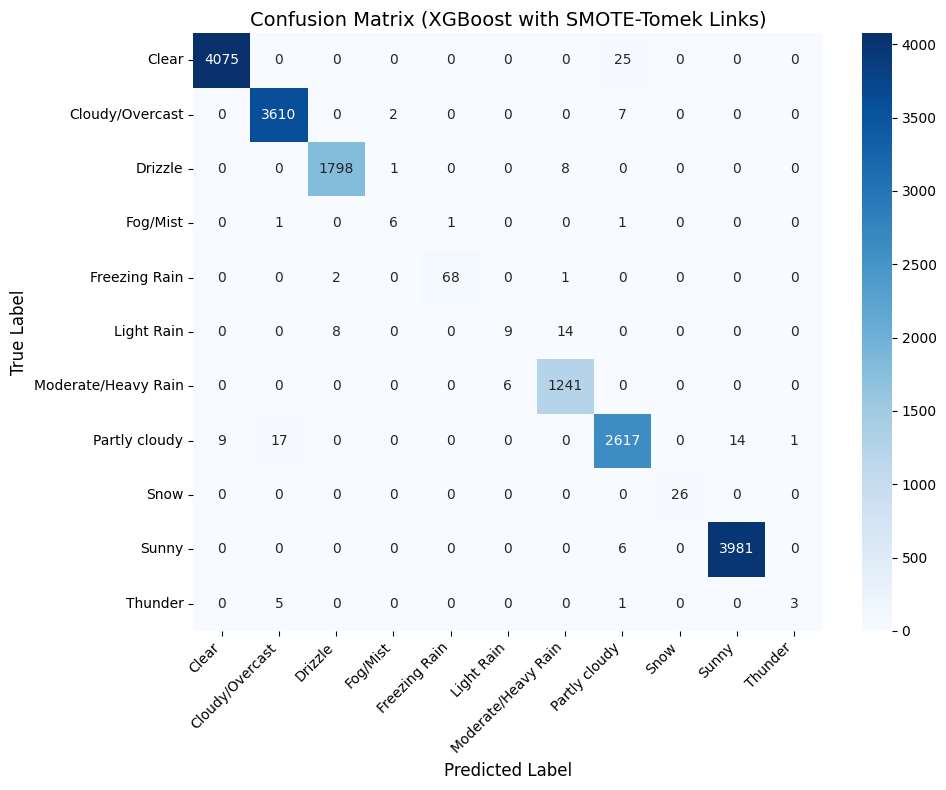

In [22]:
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (XGBoost with SMOTE-Tomek Links)', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:

pipeline_lgbm = make_pipeline(
    SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')),
    LGBMClassifier(num_leaves=500, max_depth=10,random_state=42, verbose=-1)
)
pipeline_lgbm.fit(X_train, y_train)

y_pred_lgbm = pipeline_lgbm.predict(X_test)

print("Classification Report:\n",
      classification_report(y_test, y_pred_lgbm, target_names=class_names))

Classification Report:
                      precision    recall  f1-score   support

              Clear       1.00      0.99      1.00      4100
    Cloudy/Overcast       0.99      1.00      1.00      3619
            Drizzle       0.99      1.00      1.00      1807
           Fog/Mist       0.60      0.67      0.63         9
      Freezing Rain       0.99      0.97      0.98        71
         Light Rain       0.58      0.35      0.44        31
Moderate/Heavy Rain       0.99      0.99      0.99      1247
      Partly cloudy       0.99      0.98      0.98      2658
               Snow       1.00      1.00      1.00        26
              Sunny       1.00      1.00      1.00      3987
            Thunder       1.00      0.33      0.50         9

           accuracy                           0.99     17564
          macro avg       0.92      0.84      0.86     17564
       weighted avg       0.99      0.99      0.99     17564



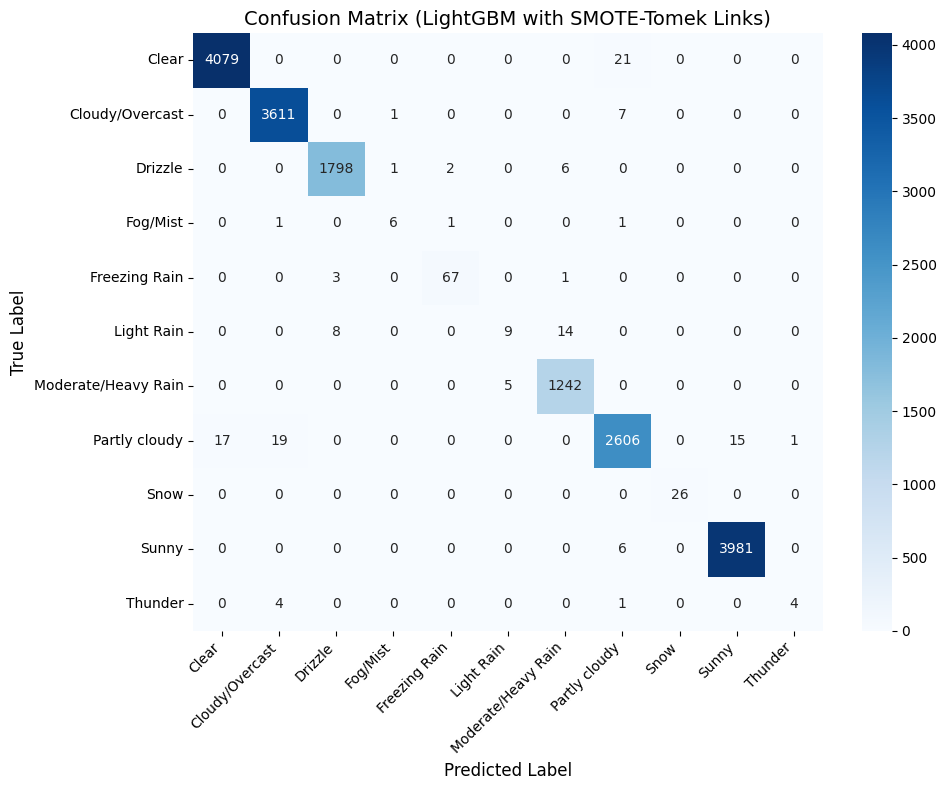

In [26]:
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (LightGBM with SMOTE-Tomek Links)', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [22]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
models_params = {
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, device='cuda'),
        "params": {
            'xgbclassifier__n_estimators': [800, 1200],
            'xgbclassifier__max_depth': [6, 12],
        }
    },
    "LightGBM": {
        "model": LGBMClassifier(random_state=42, verbose=-1, device='gpu'),
        "params": {
            'lgbmclassifier__max_depth': [10, 12],
            'lgbmclassifier__num_leaves': [500, 1000],
        }
    }
}
results = {}
best_models = {}
for model_name, config in models_params.items():
    print(f"\n=== Tinh chỉnh tham số cho {model_name} ===")
    pipeline = make_pipeline(
        SMOTETomek(sampling_strategy='auto', random_state=42),
        config["model"]
    )
    grid = GridSearchCV(pipeline, param_grid=config["params"], cv=kf, scoring='f1_macro', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[model_name] = grid.best_estimator_
    results[model_name] = {
        'Best F1 Macro (CV)': grid.best_score_
    }
    print(f"Tham số tốt nhất cho {model_name}: {grid.best_params_}")
    print(f"F1 Macro Score tốt nhất (Cross Validation): {grid.best_score_:.4f}")

# Hiển thị bảng so sánh
print("\n=== So sánh hiệu suất Cross Validation giữa các mô hình ===")
results_df = pd.DataFrame(results).T
print(results_df)


best_model_name = results_df['Best F1 Macro (CV)'].idxmax()
print(f"\nMô hình tốt nhất (dựa trên F1 Macro từ Cross Validation): {best_model_name}")


best_pipeline = best_models[best_model_name]
joblib.dump(best_pipeline, f"best_model_pipeline_{best_model_name.lower().replace(' ', '_')}.pkl")
print(f"\nĐã lưu pipeline vào best_model_pipeline_{best_model_name.lower().replace(' ', '_')}.pkl")


=== Tinh chỉnh tham số cho XGBoost ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:31:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tham số tốt nhất cho XGBoost: {'xgbclassifier__max_depth': 6, 'xgbclassifier__n_estimators': 800}
F1 Macro Score tốt nhất (Cross Validation): 0.8824

=== Tinh chỉnh tham số cho LightGBM ===


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.
